# Credit Risk Modeling Pipeline

This notebook contains a full pipeline for credit risk modeling using a LendingClub-style loans dataset. It:

- Detects and converts a multi-class loan status into a binary target (`is_bad`).
- Preprocesses numeric and categorical features (imputation, scaling, one-hot encoding).
- Handles class imbalance using SMOTE (with fallbacks).
- Trains Logistic Regression and Random Forest models.
- Evaluates models with classification reports, ROC AUC and confusion matrices.
- Attempts SHAP explainability, otherwise uses permutation importance.

**Dataset expected at**: `/mnt/data/loans_full_schema.csv`

Run cells in order.

In [2]:
# Imports & load data
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pathlib import Path
DATA_PATH = Path(r'C:\Users\vivekananda\Downloads\New folder\loans_full_schema.csv')
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Expected dataset at {DATA_PATH} not found. Upload the CSV to /mnt/data and rerun.")
df = pd.read_csv(DATA_PATH, low_memory=False)
df.head()


,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


In [3]:
# Detect target column and create binary 'is_bad' label from loan_status-like columns
possible_targets = ['loan_status','is_default','default_ind','default','bad_loan','charged_off','loan_default','target']
col_lower = {c.lower(): c for c in df.columns}
target = None
for t in possible_targets:
    if t in col_lower:
        target = col_lower[t]
        break

if target is None:
    for c in df.columns:
        if 'status' in c.lower():
            vals = df[c].astype(str).str.lower().unique()[:50]
            if any(k in ",".join(vals) for k in ['charged off','charged_off','default','late','fully paid','current']):
                target = c
                break

if target is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) == 0:
        raise ValueError('No suitable target and no numeric columns to synthesize a target.')
    candidate = numeric_cols[0]
    thresh = df[candidate].quantile(0.9)
    df['__synthetic_target__'] = (df[candidate] > thresh).astype(int)
    target = '__synthetic_target__'
    print('Created synthetic target:', target)

print('Using target column:', target)

# Create binary target
if df[target].dtype == object or df[target].dtype.name == 'category' or df[target].dtype == 'O':
    vals = df[target].astype(str).str.lower().fillna('')
    bad_keywords = ['charged', 'charge off', 'default', 'late', 'collection', 'in default', 'late (', 'bankrupt', 'settlement']
    is_bad = vals.apply(lambda s: any(k in s for k in bad_keywords))
    df['is_bad'] = is_bad.astype(int)
    y_col = 'is_bad'
else:
    unique_vals = df[target].dropna().unique()
    if set(unique_vals).issubset({0,1}):
        y_col = target
    else:
        med = df[target].median()
        df['is_bad'] = (df[target] > med).astype(int)
        y_col = 'is_bad'

print('Binary target distribution:')
print(df[y_col].value_counts(normalize=True))


Using target column: loan_status
Binary target distribution:
is_bad
0    0.9889
1    0.0111
Name: proportion, dtype: float64


In [6]:
# Feature selection, preprocessing, and train/test split
drop_patterns = ['id','member_id','url','zip_code','zipcode','emp_title','title','address','desc']
drop_cols = [c for c in df.columns if any(p in c.lower() for p in drop_patterns)]
X = df.drop(columns=list(set(drop_cols) - {y_col}), errors='ignore').copy()
y = df[y_col].copy()

missing_frac = X.isna().mean()
high_missing = missing_frac[missing_frac > 0.9].index.tolist()
if high_missing:
    X.drop(columns=high_missing, inplace=True)

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

MAX_CARD = 30
for c in cat_cols:
    top = X[c].value_counts(dropna=True).nlargest(MAX_CARD).index
    X[c] = X[c].where(X[c].isin(top), other='__Other__')

print('Features shape:', X.shape)
print('Numeric cols:', len(numeric_cols), 'Categorical cols:', len(cat_cols))

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_feats = [c for c in numeric_cols if c in X.columns]
cat_feats = [c for c in cat_cols if c in X.columns]

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer([('num', num_pipeline, num_feats),('cat', cat_pipeline, cat_feats)], remainder='drop', sparse_threshold=0)

from sklearn.model_selection import train_test_split
if y.nunique() > 1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)
print('Preprocessed shapes:', X_train_prep.shape, X_test_prep.shape)


Features shape: (10000, 51)
Numeric cols: 39 Categorical cols: 12
Train shape: (8000, 51) Test shape: (2000, 51)
Preprocessed shapes: (8000, 145) (2000, 145)


In [7]:
# Handle imbalance (SMOTE preferred), then train models
try:
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train_prep, y_train)
    print('Applied SMOTE. Resampled:', X_res.shape)
except Exception as e:
    print('SMOTE not available:', e)
    try:
        from imblearn.over_sampling import RandomOverSampler
        ros = RandomOverSampler(random_state=42)
        X_res, y_res = ros.fit_resample(X_train_prep, y_train)
        print('Applied RandomOverSampler. Resampled:', X_res.shape)
    except Exception:
        from sklearn.utils import resample
        train_df = pd.DataFrame(X_train_prep)
        train_df['__y__'] = y_train.values
        maj = train_df[train_df['__y__'] == train_df['__y__'].mode()[0]]
        mino = train_df[train_df['__y__'] != train_df['__y__'].mode()[0]]
        mino_up = resample(mino, replace=True, n_samples=len(maj), random_state=42)
        boot = pd.concat([maj, mino_up])
        X_res = boot.drop(columns='__y__').values
        y_res = boot['__y__'].values
        print('Applied naive upsampling. Resampled:', X_res.shape)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
log = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced')

log.fit(X_res, y_res)
rf.fit(X_res, y_res)
print('Training complete.')


Applied SMOTE. Resampled: (15822, 145)
Training complete.



=== Logistic Regression ===
Accuracy: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1978
           1     1.0000    1.0000    1.0000        22

    accuracy                         1.0000      2000
   macro avg     1.0000    1.0000    1.0000      2000
weighted avg     1.0000    1.0000    1.0000      2000

ROC AUC: 1.0


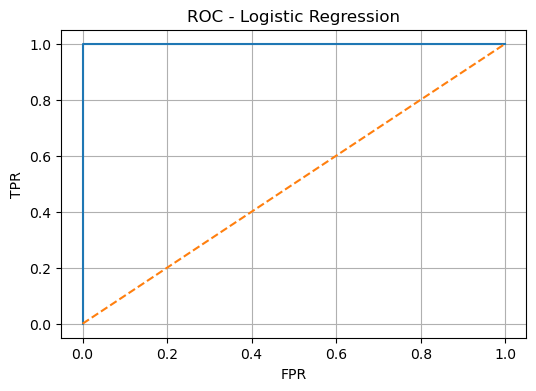

Confusion matrix:
 [[1978    0]
 [   0   22]]

=== Random Forest ===
Accuracy: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1978
           1     1.0000    1.0000    1.0000        22

    accuracy                         1.0000      2000
   macro avg     1.0000    1.0000    1.0000      2000
weighted avg     1.0000    1.0000    1.0000      2000

ROC AUC: 1.0


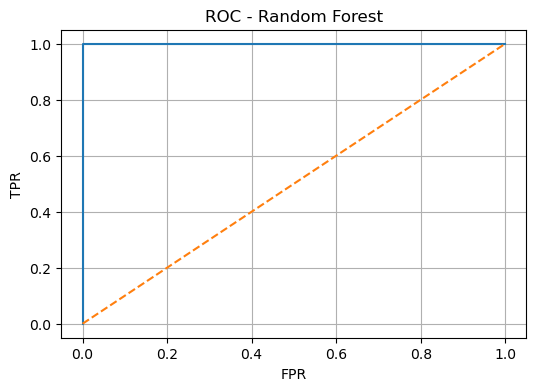

Confusion matrix:
 [[1978    0]
 [   0   22]]


In [8]:
# Evaluation on test set
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, accuracy_score
import matplotlib.pyplot as plt

def eval_model(m, Xp, yp, name):
    yp_pred = m.predict(Xp)
    print(f"\n=== {name} ===")
    print('Accuracy:', accuracy_score(yp, yp_pred))
    print(classification_report(yp, yp_pred, digits=4))
    if hasattr(m, 'predict_proba') and len(np.unique(yp))==2:
        proba = m.predict_proba(Xp)[:,1]
        auc = roc_auc_score(yp, proba)
        print('ROC AUC:', auc)
        fpr, tpr, _ = roc_curve(yp, proba)
        plt.figure(figsize=(6,4)); plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'--'); plt.title(f'ROC - {name}'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.grid(True); plt.show()
    print('Confusion matrix:\n', confusion_matrix(yp, yp_pred))

eval_model(log, X_test_prep, y_test, 'Logistic Regression')
eval_model(rf, X_test_prep, y_test, 'Random Forest')


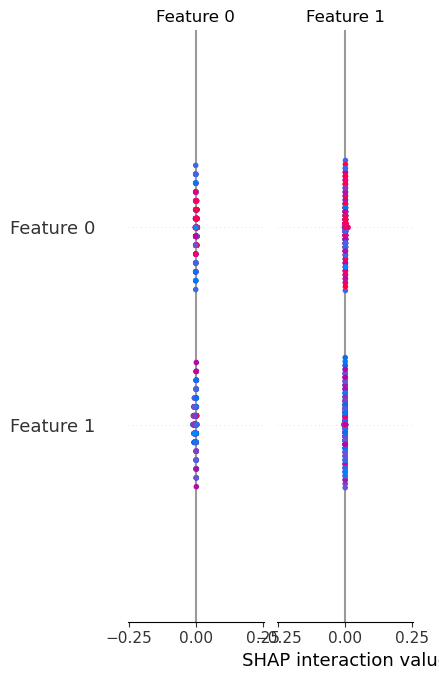

In [9]:
# Explainability: SHAP if available, else permutation importance
explained = False
try:
    import shap
    explainer = shap.TreeExplainer(rf)
    n_sample = min(200, X_test_prep.shape[0])
    idx = np.random.choice(np.arange(X_test_prep.shape[0]), size=n_sample, replace=False)
    Xs = X_test_prep[idx]
    shap_values = explainer.shap_values(Xs)
    try:
        shap.summary_plot(shap_values, Xs, show=True)
    except Exception:
        pass
    explained = True
except Exception as e:
    print('SHAP not available or failed:', e)

if not explained:
    from sklearn.inspection import permutation_importance
    perm = permutation_importance(rf, X_test_prep, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    feature_names = []
    if num_feats:
        feature_names.extend(num_feats)
    if cat_feats:
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_ohe_names = ohe.get_feature_names_out(cat_feats).tolist()
        feature_names.extend(cat_ohe_names)
    sorted_idx = perm.importances_mean.argsort()[::-1][:30]
    print('Top permutation importances:')
    for i in sorted_idx[:20]:
        fname = feature_names[i] if i < len(feature_names) else f'f{i}'
        print(fname, perm.importances_mean[i])


In [ ]:
import joblib
models = {'logistic': log, 'rf': rf}
best_name, best_m, best_score = None, None, -1
for name, m in models.items():
    try:
        p = m.predict_proba(X_test_prep)[:,1]
        sc = roc_auc_score(y_test, p)
    except Exception:
        sc = 0
    print(name, 'ROC AUC:', sc)
    if sc > best_score:
        best_score = sc; best_name = name; best_m = m

out_path = Path('credit_model.pkl')
joblib.dump({'model': best_m, 'preprocessor': preprocessor}, out_path)
print('Saved best model to', out_path)


logistic ROC AUC: 1.0
rf ROC AUC: 1.0
Saved best model to credit_model.pkl


In [ ]:
# Cell 1: Load model + preprocessor
import joblib
from pathlib import Path

model_path = Path("credit_model.pkl")  
if not model_path.exists():
    raise FileNotFoundError(f"Model file not found at {model_path}")

bundle = joblib.load(model_path)
model = bundle.get("model")
preprocessor = bundle.get("preprocessor")

print("Loaded model:", type(model).__name__)
print("Loaded preprocessor:", type(preprocessor).__name__)


Loaded model: LogisticRegression
Loaded preprocessor: ColumnTransformer


In [ ]:

import numpy as np

if hasattr(preprocessor, "feature_names_in_"):
    required_cols = list(preprocessor.feature_names_in_)
else:
    required_cols = []
    for name, transformer, cols in getattr(preprocessor, "transformers_", []):
        if isinstance(cols, (list, tuple, np.ndarray)):
            required_cols.extend(list(cols))
    required_cols = list(dict.fromkeys(required_cols))

numeric_feats = []
cat_feats = []
for name, transformer, cols in getattr(preprocessor, "transformers_", []):
    if name == 'num' and isinstance(cols, (list, tuple, np.ndarray)):
        numeric_feats = list(cols)
    if name == 'cat' and isinstance(cols, (list, tuple, np.ndarray)):
        cat_feats = list(cols)

print("Required columns:", len(required_cols))
print("Sample required columns:", required_cols[:20])
print("Numeric features count:", len(numeric_feats))
print("Categorical features count:", len(cat_feats))


Required columns: 51
Sample required columns: ['emp_length', 'state', 'homeownership', 'annual_income', 'verified_income', 'debt_to_income', 'annual_income_joint', 'verification_income_joint', 'debt_to_income_joint', 'delinq_2y', 'months_since_last_delinq', 'earliest_credit_line', 'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines', 'total_credit_limit', 'total_credit_utilized', 'num_collections_last_12m', 'num_historical_failed_to_pay', 'months_since_90d_late']
Numeric features count: 39
Categorical features count: 12


In [ ]:
import re
import pandas as pd
import numpy as np

def extract_number_from_text(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    s = s.replace(',', '').replace('%', '').strip()
    
    m = re.search(r'(-?\d+(\.\d+)?)', s)
    if m:
        try:
            return float(m.group(1))
        except:
            return np.nan
    return np.nan

def emp_length_to_years(x):
    if pd.isna(x):
        return np.nan
    s = str(x).lower().strip()
    if s in ('n/a', '', 'nan'):
        return np.nan
    if '< 1' in s or 'less' in s:
        return 0.0
    if '10+' in s:
        return 10.0
    return extract_number_from_text(s)


In [ ]:
new_applicant = {
    "loan_amount": 15000,
    "annual_income": 60000,
    "homeownership": "MORTGAGE",
    "term": "36 months",
    "loan_purpose": "debt_consolidation",
    "state": "CA",
}

import pandas as pd
new_df = pd.DataFrame([new_applicant])
print("Initial columns provided:", new_df.columns.tolist())
new_df.head()


Initial columns provided: ['loan_amount', 'annual_income', 'homeownership', 'term', 'loan_purpose', 'state']


,loan_amount,annual_income,homeownership,term,loan_purpose,state
0,15000,60000,MORTGAGE,36 months,debt_consolidation,CA


In [ ]:
aligned = new_df.reindex(columns=required_cols)  


for col in numeric_feats:
    if col in aligned.columns:
        val = aligned.loc[0, col]
        if isinstance(val, str):
            
            if col.lower() in ('emp_length', 'employment_length', 'emp_length_years'):
                aligned.loc[0, col] = emp_length_to_years(val)
            else:
                num = extract_number_from_text(val)
                aligned.loc[0, col] = num

for col in numeric_feats:
    if col in aligned.columns:
        aligned[col] = pd.to_numeric(aligned[col], errors='coerce')

defaults = {
    "installment": 0.0,
    "interest_rate": 0.0,
    "annual_income": 0.0,
    "emp_length": np.nan,   
}
for c, v in defaults.items():
    if c in aligned.columns:
        aligned[c] = aligned[c].fillna(v)


print("Aligned row shape:", aligned.shape)
print("Top missing counts (showing up to 20):")
print(aligned.isna().sum().sort_values(ascending=False).head(20))
aligned.iloc[:, :20]


Aligned row shape: (1, 51)
Top missing counts (showing up to 20):
emp_length                      1
accounts_opened_24m             1
num_accounts_120d_past_due      1
num_accounts_30d_past_due       1
num_active_debit_accounts       1
total_debit_limit               1
num_total_cc_accounts           1
num_open_cc_accounts            1
num_cc_carrying_balance         1
num_mort_accounts               1
account_never_delinq_percent    1
tax_liens                       1
public_record_bankrupt          1
application_type                1
grade                           1
sub_grade                       1
issue_month                     1
loan_status                     1
initial_listing_status          1
disbursement_method             1
dtype: int64


,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late
0,NaN,CA,MORTGAGE,60000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for c in cat_feats:
    if c in aligned.columns:
        aligned[c] = aligned[c].astype(object)

X_new_prep = preprocessor.transform(aligned)   

# Predict
pred = model.predict(X_new_prep)[0]
proba = model.predict_proba(X_new_prep)[0][1] if hasattr(model, "predict_proba") else None

print("Prediction (0 = good, 1 = bad):", pred)
print("Probability of bad (if available):", proba)


Prediction (0 = good, 1 = bad): 0
Probability of bad (if available): 7.206011579774368e-05
